In [1]:

%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Read the data
For both the heatmaps and the featuremaps, extract the data about
- The approaches used.
- The clusters obtained with each approach.
- The time taken to compute the clusters.

For the featuremaps, the data might be filtered for some specific configuration.

In [2]:
import pandas as pd

# Read the featuremaps clusters data
featuremaps_df = pd.read_pickle('../logs/feature_combinations_clusters')
# Compute the total time
featuremaps_df['time'] = featuremaps_df['map_time'] + featuremaps_df['features_extraction']
featuremaps_df = featuremaps_df.drop(columns=['map_time', 'features_extraction'])

# Filter for the desired approach
featuremaps_df = featuremaps_df[
    # (featuremaps_df['map_size']  == '10x10') &
    (featuremaps_df['mode'] == 'original')
]

featuremaps_df['approach'] = featuremaps_df.apply(
    lambda row: f'{row["approach"]}({row["map_size"]})_{row["mode"]}',
    axis=1
)

featuremaps_df

,approach,map_size,mode,clusters,time
0,moves+bitmaps(10x10)_original,10x10,original,"[[670], [48, 163, 252, 254, 274, 279, 401, 426...",33.516399
2,moves+orientation(10x10)_original,10x10,original,"[[28, 119, 263, 277, 339, 453], [20, 38, 72, 8...",33.548912
4,orientation+bitmaps(10x10)_original,10x10,original,"[[28, 339, 453], [119, 263, 277], [248], [252,...",33.514015
6,moves+bitmaps(25x25)_original,25x25,original,"[[670], [48, 274, 279, 520], [252, 254, 426, 5...",35.459562
8,moves+orientation(25x25)_original,25x25,original,"[[339], [28, 277, 453], [119, 125, 210, 263, 3...",35.500076
10,orientation+bitmaps(25x25)_original,25x25,original,"[[339], [453], [28], [277], [125], [263], [119...",35.661948


In [3]:
import pandas as pd

# Read the heatmaps data
heatmaps_df = pd.read_pickle('../logs/heatmaps_data')
# Get the tuples linking each approach to its best configuration
heatmaps_df['perplexity'] = heatmaps_df['dim_red_techs_params'].apply(lambda params: float(params[-1]['perplexity']))
best_configs_df = pd.read_csv('../logs/best_configs.csv')
best_config_combs = list(
        best_configs_df[['explainer', 'perplexity']].itertuples(index=False, name=None)
    )
# Filter the data for the best configurations
heatmaps_df = heatmaps_df[heatmaps_df[['explainer', 'perplexity']].apply(tuple, axis=1).isin(best_config_combs)]

# Drop the values with null silhouette score
heatmaps_df = heatmaps_df.dropna(subset=['silhouette']).reset_index(drop=True)
# Keep the column of interest
heatmaps_df = heatmaps_df[['clustering_mode', 'explainer', 'clustering_technique', 'clusters', 'time_clustering', 'time_contributions']]
heatmaps_df = heatmaps_df.rename(columns={'explainer': 'approach'})
# Merge the information for the clustering mode
heatmaps_df['clustering_mode'] = heatmaps_df.apply(lambda row: f'{row["clustering_technique"]}({row["clustering_mode"]})', axis=1)
heatmaps_df = heatmaps_df.drop(columns=['clustering_technique'])
# Compute the total time
heatmaps_df['time'] = heatmaps_df['time_clustering'] + heatmaps_df['time_contributions']
heatmaps_df = heatmaps_df.drop(columns=['time_clustering', 'time_contributions'])

heatmaps_df.head()

,clustering_mode,approach,clusters,time
0,AffinityPropagation(LocalLatentMode),DeconvNet,"[[0, 640, 6, 134, 18, 21, 408, 152, 26, 27, 42...",3.50935
1,AffinityPropagation(LocalLatentMode),DeconvNet,"[[0, 263, 394, 523, 270, 145, 18, 281, 156, 16...",3.31807
2,AffinityPropagation(LocalLatentMode),DeconvNet,"[[0, 129, 640, 519, 145, 18, 404, 408, 281, 28...",4.10746
3,AffinityPropagation(LocalLatentMode),DeconvNet,"[[0, 513, 640, 3, 646, 392, 145, 18, 404, 661,...",3.75270
4,AffinityPropagation(LocalLatentMode),DeconvNet,"[[0, 263, 519, 394, 523, 525, 270, 18, 19, 156...",4.13952


In [4]:
from utils.dataset import get_train_test_data, get_data_masks
import pandas as pd
import numpy as np

# Merge all the clusters together
complete_df = pd.concat([featuremaps_df, heatmaps_df]).reset_index(drop=True)

# Extract the data about the number of clusters
complete_df['num_clusters'] = complete_df['clusters'].apply(len)
# Extract data about the clusters sizes
complete_df['clusters_sizes'] = complete_df['clusters'].apply(lambda clusters: [len(cluster) for cluster in clusters])

# Get the indexes of the misclassified elements
(train_data, train_labels), (test_data, test_labels) = get_train_test_data(rgb=True)
predictions = np.loadtxt('../in/predictions.csv')
mask_miss, mask_label = get_data_masks(test_labels, predictions, label=5)
mask_miss_label = mask_miss[mask_label]
misclassified_idxs = np.argwhere(mask_miss_label == True)
# Find the fraction of misclassified data in each cluster
complete_df['frac_misses'] = complete_df['clusters'].apply(
    lambda clusters: [
        len([entry for entry in cluster if entry in misclassified_idxs]) / len(cluster)
        for cluster in clusters
    ]
)
# Find the fraction of clusters containing both correct and incorrect classifications
complete_df['frac_mixed'] = complete_df['frac_misses'].apply(lambda misses: len([entry for entry in misses if 0 < entry < 1]) / len(misses))

complete_df.to_pickle('../logs/stats')
complete_df.to_csv('../logs/stats', index=False)
complete_df

2022-05-09 19:31:09.823639: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


,approach,map_size,mode,clusters,time,clustering_mode,num_clusters,clusters_sizes,frac_misses,frac_mixed
0,moves+bitmaps(10x10)_original,10x10,original,"[[670], [48, 163, 252, 254, 274, 279, 401, 426...",33.516399,NaN,47,"[1, 15, 90, 222, 208, 148, 90, 21, 6, 1, 1, 1,...","[1.0, 0.4666666666666667, 0.3111111111111111, ...",0.319149
1,moves+orientation(10x10)_original,10x10,original,"[[28, 119, 263, 277, 339, 453], [20, 38, 72, 8...",33.548912,NaN,44,"[6, 41, 76, 115, 118, 220, 176, 42, 7, 1, 1, 2...","[0.16666666666666666, 0.4146341463414634, 0.31...",0.431818
2,orientation+bitmaps(10x10)_original,10x10,original,"[[28, 339, 453], [119, 263, 277], [248], [252,...",33.514015,NaN,55,"[3, 3, 1, 2, 3, 16, 16, 3, 2, 5, 26, 15, 24, 9...","[0.3333333333333333, 0.0, 0.0, 1.0, 0.66666666...",0.709091
3,moves+bitmaps(25x25)_original,25x25,original,"[[670], [48, 274, 279, 520], [252, 254, 426, 5...",35.459562,NaN,88,"[1, 4, 8, 11, 34, 48, 80, 79, 91, 83, 75, 66, ...","[1.0, 0.75, 0.25, 0.6363636363636364, 0.441176...",0.261364
4,moves+orientation(25x25)_original,25x25,original,"[[339], [28, 277, 453], [119, 125, 210, 263, 3...",35.500076,NaN,92,"[1, 3, 5, 5, 20, 22, 34, 33, 40, 42, 48, 46, 4...","[1.0, 0.0, 0.2, 0.8, 0.4, 0.36363636363636365,...",0.250000
...,...,...,...,...,...,...,...,...,...,...
194,Rise,NaN,NaN,"[[0, 260, 6, 648, 394, 147, 21, 412, 163, 803,...",1140.007290,AffinityPropagation(LocalLatentMode),26,"[29, 52, 30, 34, 31, 25, 36, 39, 40, 40, 37, 1...","[0.2413793103448276, 0.15384615384615385, 0.06...",0.692308
195,Rise,NaN,NaN,"[[0, 260, 6, 394, 17, 147, 21, 407, 412, 163, ...",1139.972520,AffinityPropagation(LocalLatentMode),28,"[33, 32, 50, 39, 21, 34, 39, 41, 33, 34, 31, 1...","[0.45454545454545453, 0.03125, 0.06, 0.0512820...",0.571429
196,Rise,NaN,NaN,"[[0, 260, 6, 394, 17, 147, 21, 407, 26, 412, 1...",1140.929470,AffinityPropagation(LocalLatentMode),27,"[41, 49, 53, 30, 39, 38, 32, 33, 30, 42, 29, 3...","[0.43902439024390244, 0.08163265306122448, 0.0...",0.629630
197,Rise,NaN,NaN,"[[0, 260, 6, 648, 394, 147, 21, 412, 163, 803,...",1139.711590,AffinityPropagation(LocalLatentMode),28,"[29, 26, 33, 38, 52, 53, 22, 37, 26, 40, 28, 3...","[0.2413793103448276, 0.0, 0.06060606060606061,...",0.642857


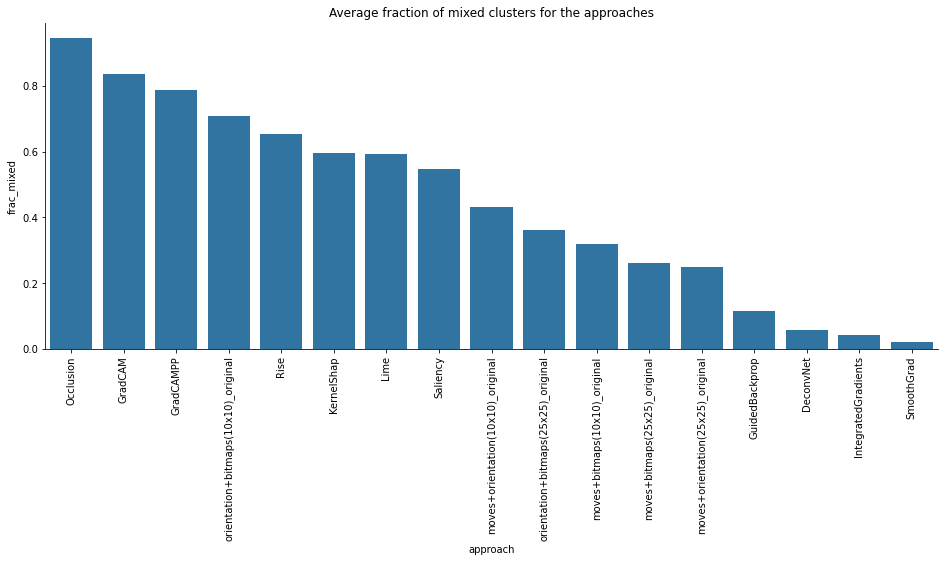

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from utils.general import save_figure

fig = plt.figure(figsize=(16,6))
sns.barplot(
    x='approach',
    y='frac_mixed',
    data=complete_df.groupby('approach')[['frac_mixed']].mean().reset_index(drop=False).sort_values('frac_mixed', ascending=False),
    color=sns.color_palette(n_colors=1)[0]
).set_title('Average fraction of mixed clusters for the approaches')
plt.xticks(rotation=90)
sns.despine()
save_figure(fig, '/Users/lodovicoazzini/Desktop/explore_data/frac_mixed')

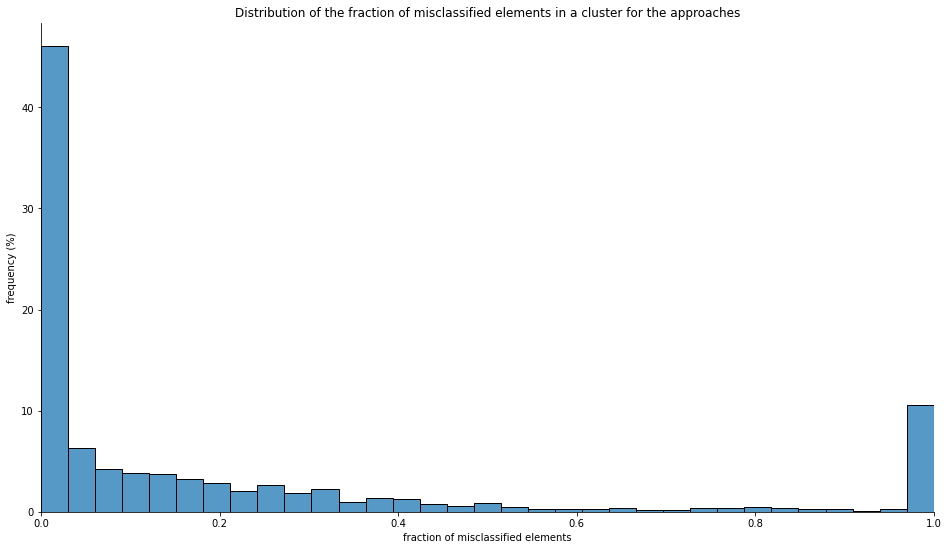

In [6]:
frac_misses = [frac_misses for frac_misses_list in complete_df['frac_misses'].values for frac_misses in frac_misses_list]
fig = plt.figure(figsize=(16,9))
ax = sns.histplot(frac_misses, stat='percent')
ax.set_title('Distribution of the fraction of misclassified elements in a cluster for the approaches')
ax.set_xlabel('fraction of misclassified elements')
ax.set_ylabel('frequency (%)')
sns.despine()
plt.xlim(0, 1)
save_figure(fig, '/Users/lodovicoazzini/Desktop/explore_data/frac_misses_dist')

# Explore the most common clusters across the different approaches
Consider the clusters in all the approaches and find the ones occurring more often.

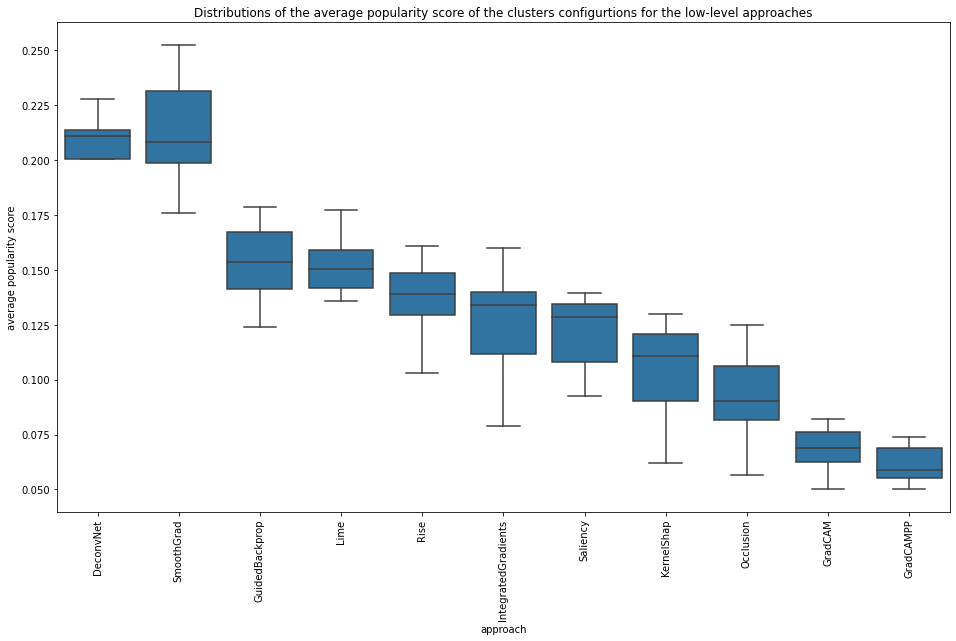

In [7]:
from utils.cluster.postprocessing import get_popularity_score
import matplotlib.pyplot as plt
import seaborn as sns
from utils.general import save_figure

selected_clusters = pd.DataFrame.copy(complete_df, deep=True)
# Find all the clusters configurations and the number of samples for each approach
approaches_merged = complete_df.groupby('approach').agg({'clusters': [sum, len]})
# Find the popularity score of each cluster configuration
selected_clusters['popularity_score'] = selected_clusters.apply(
    lambda row: get_popularity_score(
        row['clusters'],
        approaches_merged.loc[row['approach']].loc['clusters', 'sum'],
        approaches_merged.loc[row['approach']].loc['clusters', 'len']
    ),
    axis=1
)

# Show the distributions of the popularity score for each low-level approach
fig = plt.figure(figsize=(16,9))
plot_data = selected_clusters[~selected_clusters['clustering_mode'].isna()]
plot_data = plot_data.set_index('approach').loc[
plot_data.groupby('approach')['popularity_score'].median().sort_values(ascending=False).index
]
ax = sns.boxplot(x = plot_data.index, y='popularity_score', data=plot_data, color=sns.color_palette()[0], showfliers=False)
ax.set_title('Distributions of the average popularity score of the clusters configurtions for the low-level approaches')
ax.set_ylabel('average popularity score')
plt.xticks(rotation=90)
save_figure(fig, '/Users/lodovicoazzini/Desktop/explore_data/avg_popularity_score')

# For each approach, choose the cluster configuration with the highest popularity score
selected_clusters['rank'] = selected_clusters.groupby('approach')['popularity_score'].rank(method='dense', ascending=False).astype(int)
selected_clusters = selected_clusters[selected_clusters['rank'] == 1].drop(columns='rank')

Text(0.5, 0.98, 'Most common clusters across the different approaches')

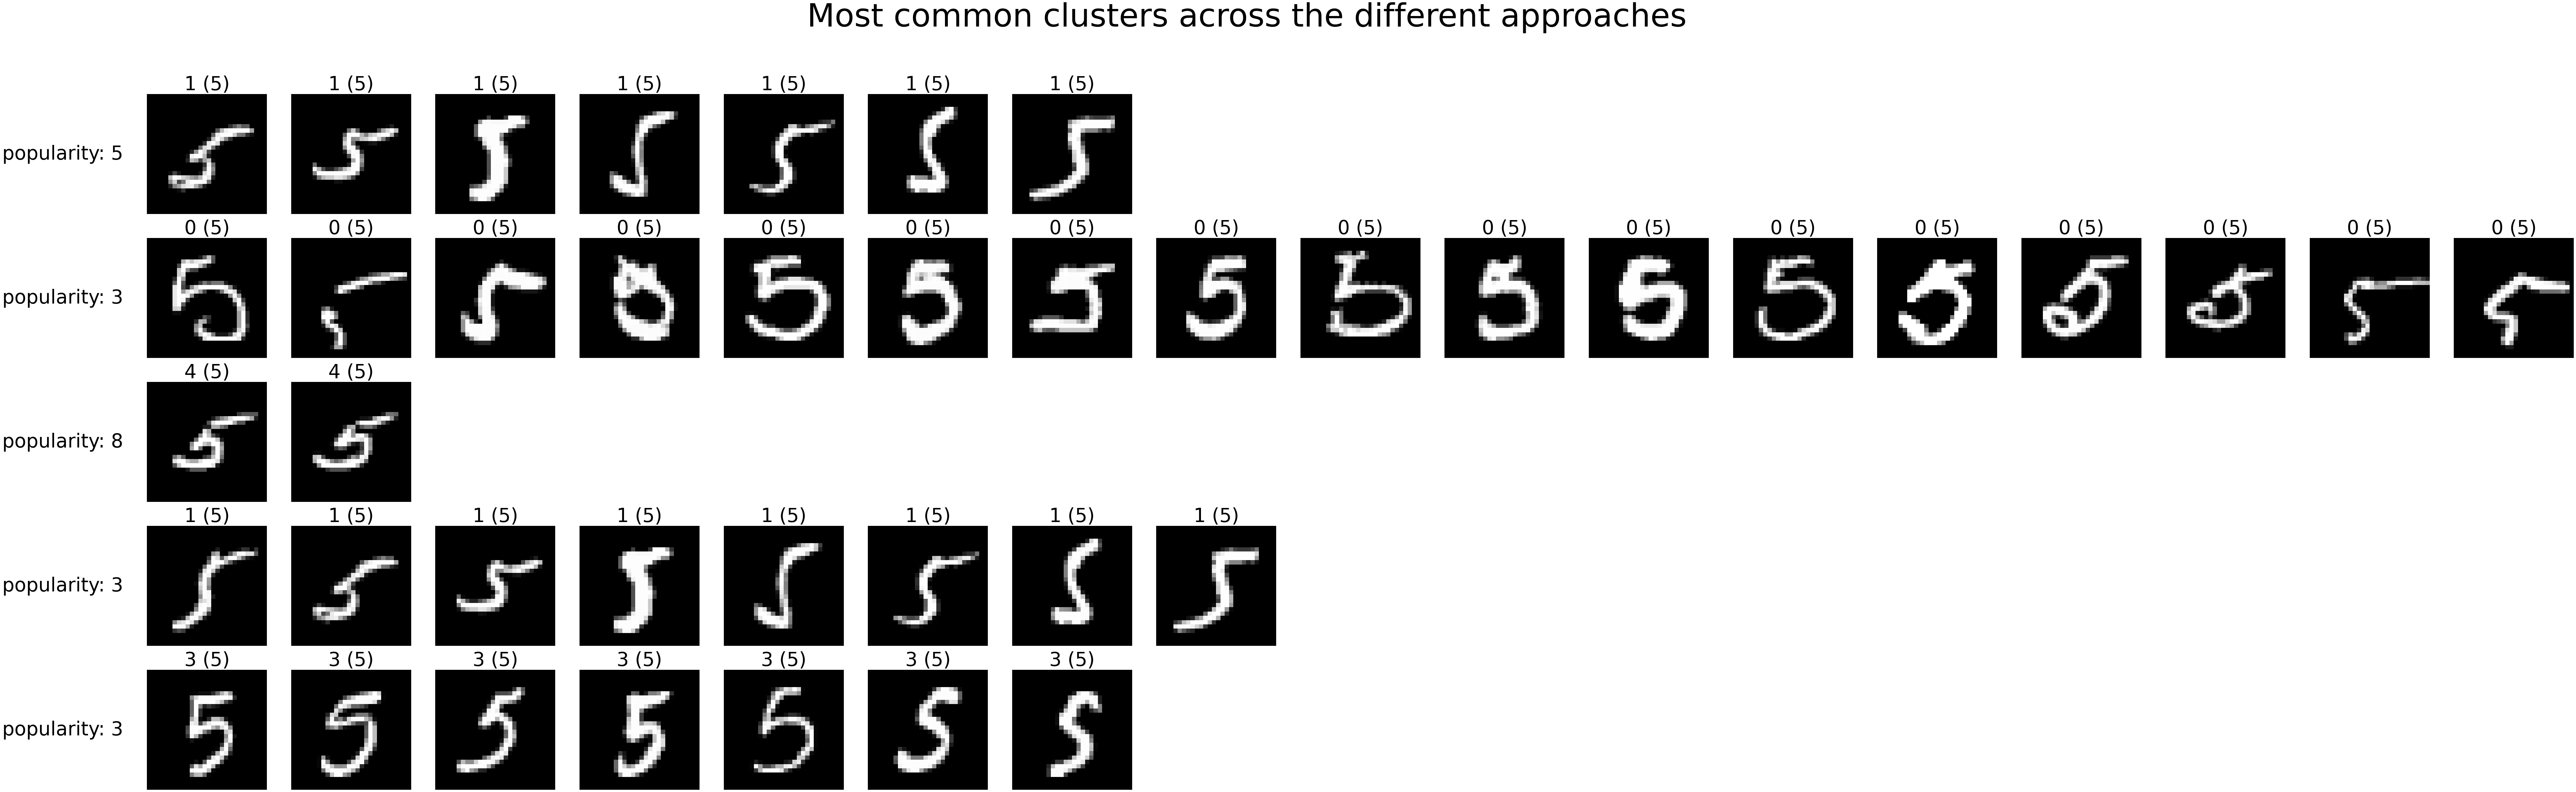

In [8]:
from utils.general import get_common_clusters, weight_values
import numpy as np
import math

# Get the most common clusters
most_common_clusters, clusters_popularity = zip(*[
    (cluster, popularity) for cluster, popularity
    in get_common_clusters(selected_clusters['clusters'].values, mask=mask_miss_label)
    if popularity > 1
])
most_common_clusters = np.array(most_common_clusters, dtype=list)
clusters_popularity = np.array(clusters_popularity)
# Sort the clusters by popularity weighted by their size
clusters_len = np.array([len(cluster) for cluster in most_common_clusters])
weighted_popularity = weight_values(clusters_popularity, np.array([math.log(val) for val in clusters_len]))
most_common_clusters = most_common_clusters[np.argsort(-weighted_popularity)]
clusters_popularity = clusters_popularity[np.argsort(-weighted_popularity)]
most_common_clusters = most_common_clusters[:5]
clusters_popularity = clusters_popularity[:5]

# Get the number of rows and columns
n_rows = len(most_common_clusters)
n_cols = max(map(len, most_common_clusters)) + 1
# Create the figure
fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols*8, n_rows*8))
# Iterate through the clusters
for ax_row, cluster, popularity in zip(ax, most_common_clusters, clusters_popularity):
    # Show the popularity of the cluster
    ax_row[0].text(
        .5, .5,
        f'popularity: {popularity}',
        horizontalalignment='center', verticalalignment='center',
        size=60
    )
    # Show the images in the cluster
    for axx, idx in zip(ax_row[1:], cluster):
        axx.imshow(test_data[mask_label][idx], cmap='gray_r')
        axx.set_title(
            f'{int(predictions[mask_label][idx])} ({test_labels[mask_label][idx]})',
            size=60
        )

for axx in ax.flatten():
    axx.axis('off')

fig.suptitle('Most common clusters across the different approaches', size=100)

# Compute the distance matrix for all the approaches (low-level + high-level)

In [88]:
from utils.cluster.preprocessing import distance_matrix
from clusim.clustering import Clustering

clusters_configs = complete_df['clusters'].values
_, fig, ax = distance_matrix(
        [Clustering().from_cluster_list(clusters) for clusters in clusters_configs],
        lambda l, r: 1 - element_sim(l, r),
        show_map=True,
        names=complete_df['approach']
    )
ax.set_title('Distances between the clusters obtained with different explainers')

save_figure(fig, '/Users/lodovicoazzini/Desktop/explore_data/dist_matrix_complete')

KeyboardInterrupt: 

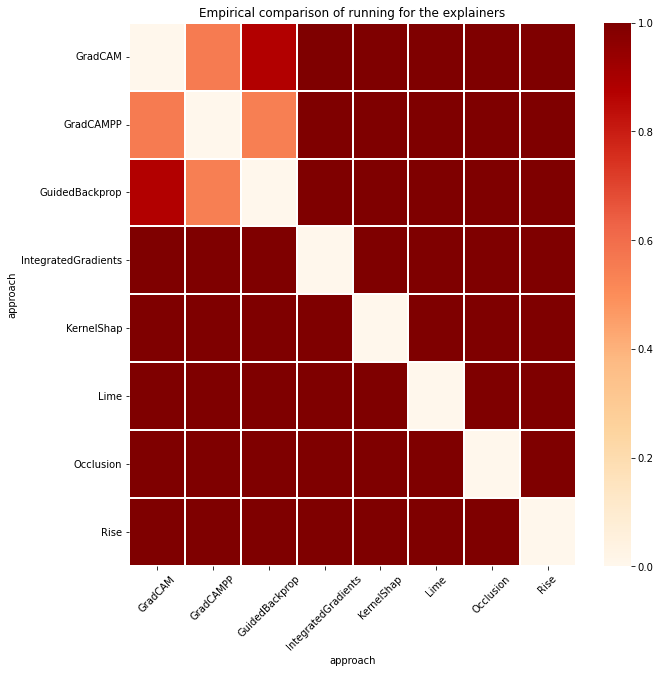

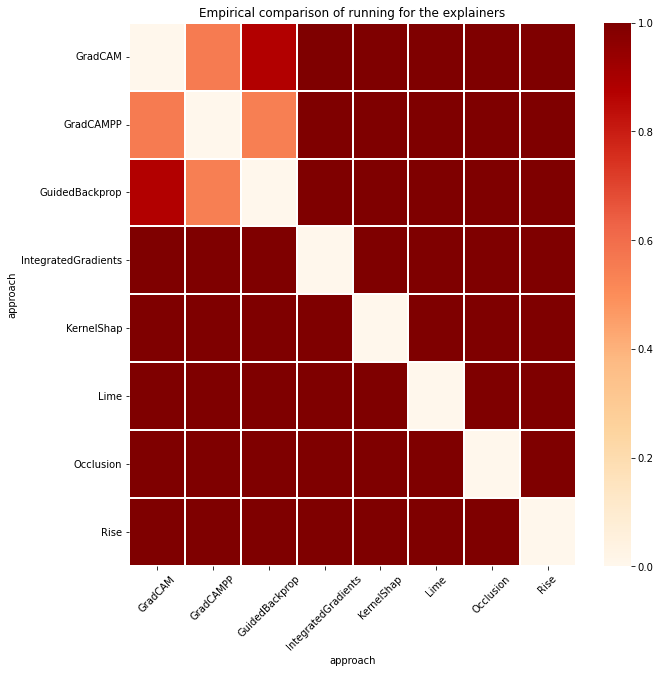

In [216]:
from utils.cluster.preprocessing import distance_matrix
from utils.stats import compare_distributions
from utils.general import save_figure

plot_data = complete_df[complete_df['clustering_mode'].notnull()]
plot_data = plot_data.groupby('approach')[['time']].agg(lambda x: [e for e in x])
plot_data = plot_data.drop('SmoothGrad')

def get_cell_content(lhs, rhs):
    is_relevant, p_value, eff_size, eff_size_str = compare_distributions(lhs, rhs)
    return abs(eff_size) if is_relevant else None

_, fig, ax = distance_matrix(
    plot_data['time'].values,
    dist_func=lambda lhs, rhs: get_cell_content(lhs, rhs),
    show_map=True,
    names=plot_data.index
)
ax.set_title('Empirical comparison of running for the explainers')
save_figure(fig, './Users/lodovicoazzini/Desktop/explore_data/compare_running_time')

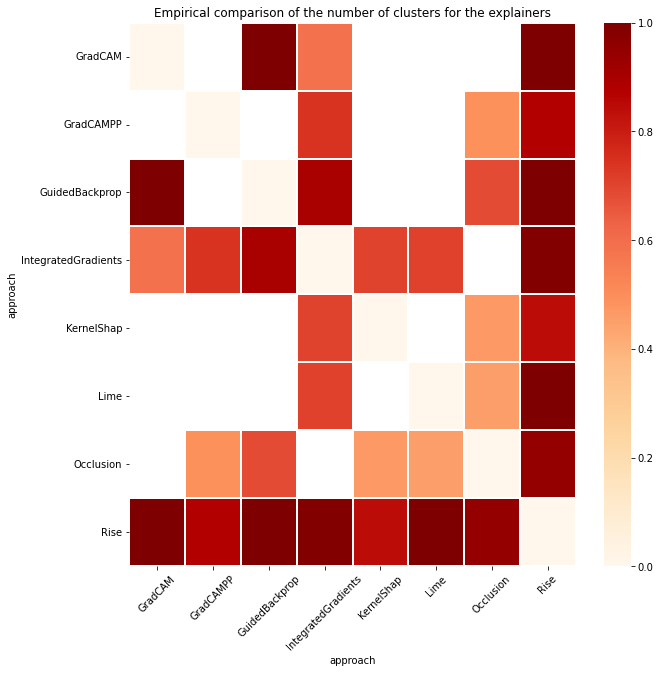

In [220]:
plot_data = complete_df[complete_df['clustering_mode'].notnull()]
plot_data = plot_data.groupby('approach')[['num_clusters']].agg(lambda x: [e for e in x])
plot_data = plot_data.drop('SmoothGrad')

_, fig, ax = distance_matrix(
    plot_data['num_clusters'].values,
    dist_func=lambda lhs, rhs: get_cell_content(lhs, rhs),
    show_map=True,
    names=plot_data.index
)
ax.set_title('Empirical comparison of the number of clusters for the explainers')
save_figure(fig, '/Users/lodovicoazzini/Desktop/explore_data/compare_num_clusters')

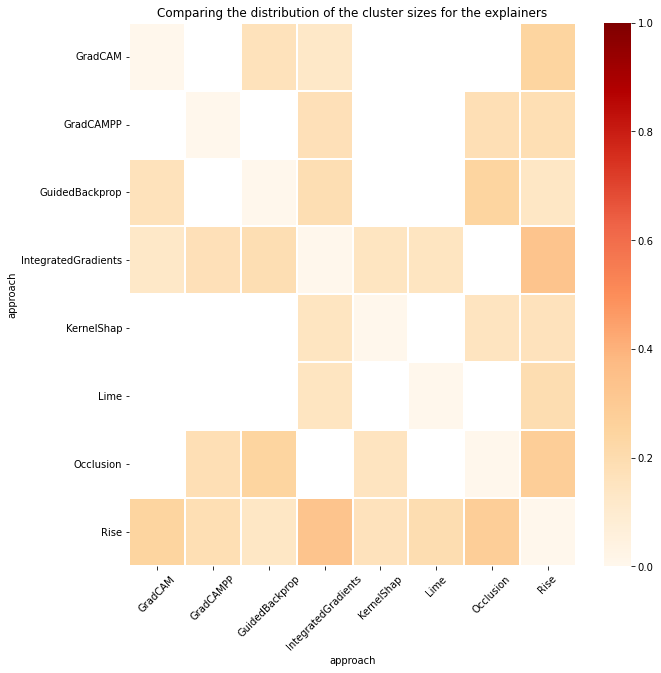

In [228]:
plot_data = complete_df[complete_df['clustering_mode'].notnull()]
plot_data = plot_data.groupby('approach')['clusters_sizes'].agg(lambda data: [cluster_size for cluster_sizes in data for cluster_size in cluster_sizes])
plot_data = plot_data.drop('SmoothGrad')

_, fig, ax = distance_matrix(
    plot_data.values,
    dist_func=lambda lhs, rhs: get_cell_content(lhs, rhs),
    show_map=True,
    names=plot_data.index
)
ax.set_title('Comparing the distribution of the cluster sizes for the explainers')
save_figure(fig, '/Users/lodovicoazzini/Desktop/explore_data/compare_clusters_sizes')

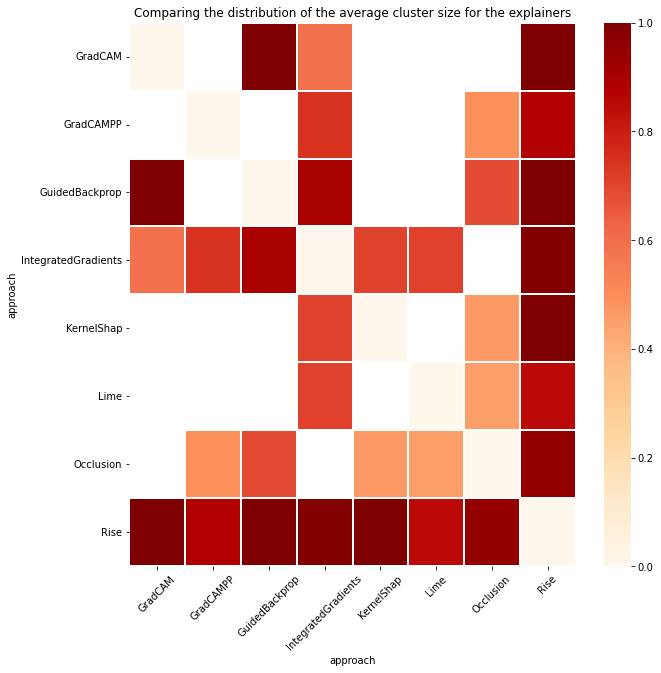

In [229]:


plot_data = complete_df[complete_df['clustering_mode'].notnull()]
plot_data = plot_data.groupby('approach')['clusters_sizes'].agg(lambda data: [np.average(cluster_sizes) for cluster_sizes in data])
plot_data = plot_data.drop('SmoothGrad')

_, fig, ax = distance_matrix(
    plot_data.values,
    dist_func=lambda lhs, rhs: get_cell_content(lhs, rhs),
    show_map=True,
    names=plot_data.index
)
ax.set_title('Comparing the distribution of the average cluster size for the explainers')
save_figure(fig, '/Users/lodovicoazzini/Desktop/explore_data/compare_average_clusters_sizes')

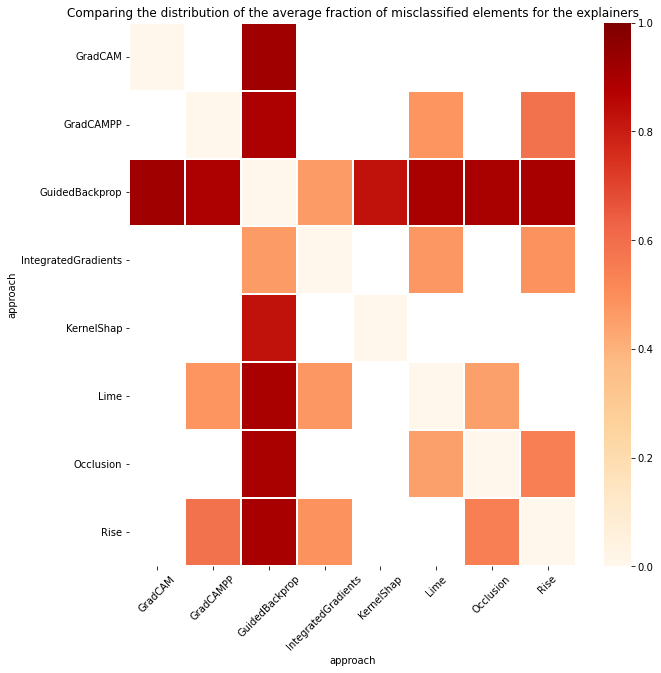

In [236]:
plot_data = complete_df[complete_df['clustering_mode'].notnull()]
plot_data = plot_data.groupby('approach')['frac_misses'].agg(lambda data: [np.average(misses) for misses in data])
plot_data = plot_data.drop('SmoothGrad')

_, fig, ax = distance_matrix(
    plot_data.values,
    dist_func=lambda lhs, rhs: get_cell_content(lhs, rhs),
    show_map=True,
    names=plot_data.index
)
ax.set_title('Comparing the distribution of the average fraction of misclassified elements for the explainers')
save_figure(fig, '/Users/lodovicoazzini/Desktop/explore_data/compare_average_frac_misses')

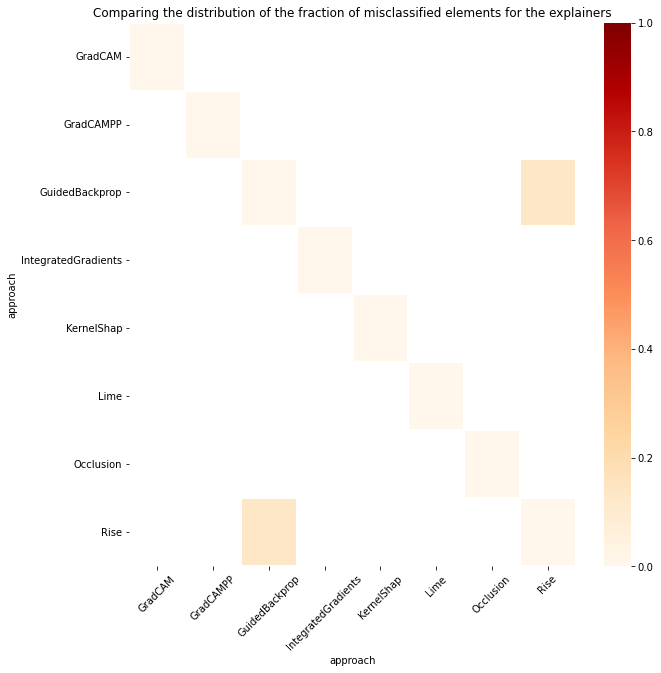

In [232]:
plot_data = complete_df[complete_df['clustering_mode'].notnull()]
plot_data = plot_data.groupby('approach')['frac_misses'].agg(lambda data: [miss for misses in data for miss in misses])
plot_data = plot_data.drop('SmoothGrad')

_, fig, ax = distance_matrix(
    plot_data.values,
    dist_func=lambda lhs, rhs: get_cell_content(lhs, rhs),
    show_map=True,
    names=plot_data.index
)
ax.set_title('Comparing the distribution of the fraction of misclassified elements for the explainers')
save_figure(fig, '/Users/lodovicoazzini/Desktop/explore_data/compare_frac_misses')

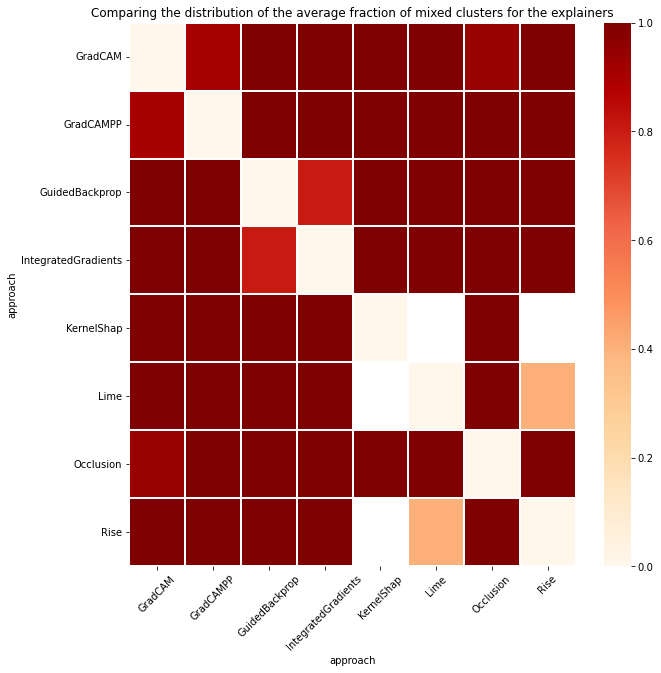

In [233]:
plot_data = complete_df[complete_df['clustering_mode'].notnull()]
plot_data = plot_data.groupby('approach')['frac_mixed'].agg(lambda data: [mixed for mixed in data])
plot_data = plot_data.drop('SmoothGrad')

_, fig, ax = distance_matrix(
    plot_data.values,
    dist_func=lambda lhs, rhs: get_cell_content(lhs, rhs),
    show_map=True,
    names=plot_data.index
)
ax.set_title('Comparing the distribution of the average fraction of mixed clusters for the explainers')
save_figure(fig, '/Users/lodovicoazzini/Desktop/explore_data/compare_avg_frac_mixed')

In [76]:
from utils.cluster.postprocessing import get_filtered_clusters
from utils.cluster.preprocessing import distance_matrix
from clusim.sim import element_sim
from clusim.clustering import Clustering
from utils.general import beep, save_figure

complete_df['miss_clusters'] = complete_df['clusters'].apply(lambda clusters: get_filtered_clusters(clusters, mask=mask_miss_label))
clusters_configs = complete_df['miss_clusters'].values
_, fig, ax = distance_matrix(
        [Clustering().from_cluster_list(clusters) for clusters in clusters_configs],
        lambda l, r: 1 - element_sim(l, r),
        show_map=True,
        names=complete_df['approach']
    )

ax.set_title('Distances of the clusters for misclassified images')
save_figure(fig, '/Users/lodovicoazzini/Desktop/miss_clusters_dist_matrix')

beep()

KeyboardInterrupt: 

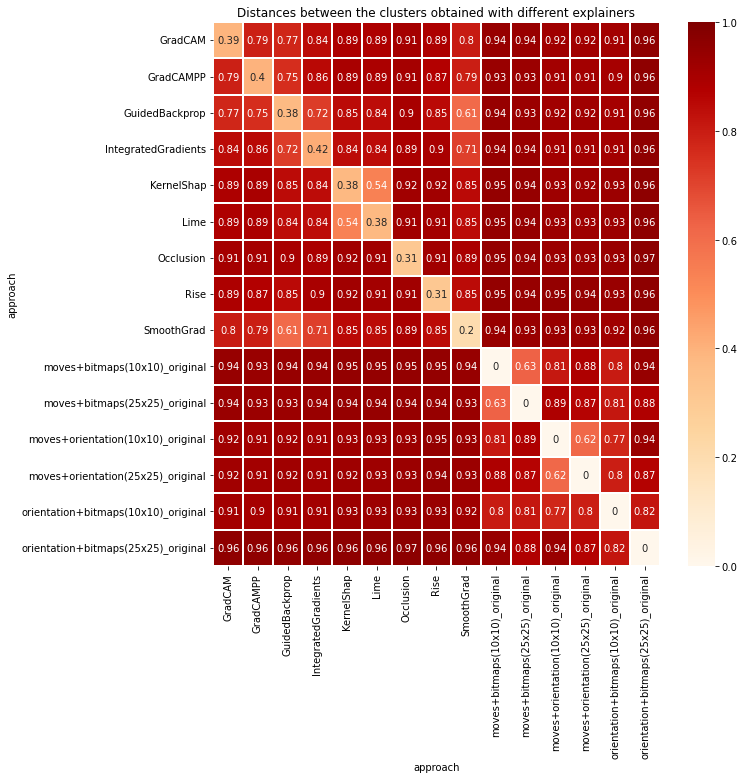

In [60]:

from utils.cluster.preprocessing import distance_matrix
from clusim.clustering import Clustering

clusters_configs = complete_df['clusters'].values
_, fig, ax = distance_matrix(
        [Clustering().from_cluster_list(clusters) for clusters in clusters_configs],
        lambda l, r: 1 - element_sim(l, r),
        show_map=True,
        names=complete_df['approach']
    )
ax.set_title('Distances between the clusters obtained with different explainers')

save_figure(fig, '/Users/lodovicoazzini/Desktop/clusters_dist_matrix')

beep()